In [62]:
import numpy as np
from matplotlib import pyplot as plt
import random
import math

DEBUGGING = False

## 2 Trees and Random Forests
(a)

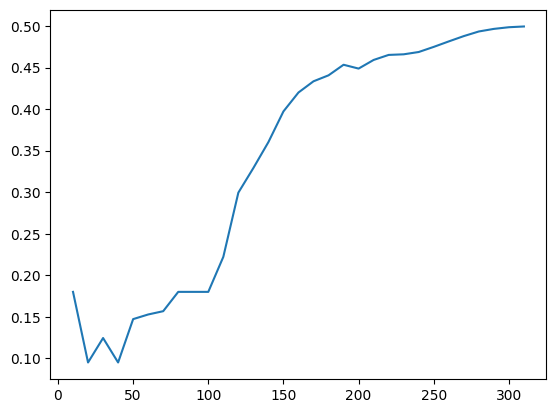

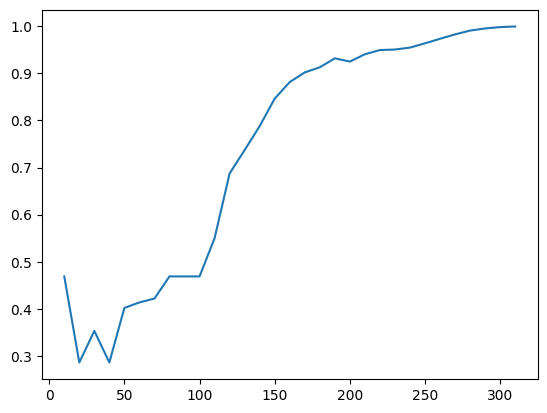

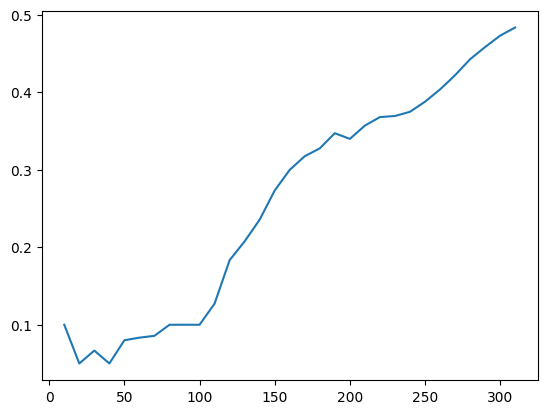

In [58]:
# load the data
pts = np.load('Data/data1d.npy')
labels = np.load('Data/labels1d.npy')

# TODO: Sort the points to easily split them
sorted_indices = np.argsort(pts)
sorted_data = pts[sorted_indices]
sorted_labels = labels[sorted_indices]
total_size = len(sorted_data)

# TODO: Implement or find implementation for Gini impurity, entropy and misclassifcation rate
def impurity_calculator(labels):
    number_of_measurements = len(labels)
    class_counts = {}

    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    gini_impurity = 1.0
    
    for label in class_counts:
        probability = class_counts[label] / number_of_measurements
        gini_impurity -= probability ** 2
        
    return gini_impurity

def entropy_calculator(labels):
    number_of_measurements = len(labels)
    class_counts = {}

    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    entropy = 0.0
    for label in class_counts:
        probability = class_counts[label] / number_of_measurements
        entropy -= probability * math.log2(probability)
        
    return entropy

def misclassification_rate_calculator(labels):
    number_of_measurements = len(labels)
    class_counts = {}

    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1
        
    if class_counts == {}:
        return 0
        
    most_frequent_class = max(class_counts, key=class_counts.get)
    error_count = number_of_measurements - class_counts[most_frequent_class]
    misclassification_error = error_count / number_of_measurements
        
    return misclassification_error

# TODO: Iterate over the possible splits, evaulating and saving the three criteria for each one
impurities = []
entropies = []
errors = []

for i in range(10, total_size, 10):
    
    test_values = np.split(sorted_data, [i])
    test_labels = np.split(sorted_labels, [i])        

    impurities.append(impurity_calculator(test_labels[0]))
    entropies.append(entropy_calculator(test_labels[0]))
    errors.append(misclassification_rate_calculator(test_labels[0]))

    if DEBUGGING:
        print(number_of_test_subjects)
        print(len(test_values[0]))
        print("Gini impurity -- ", impurities[len(impurities) - 1])
        print("entropy -- ", entropies[len(entropies) - 1])
        print("misclassification -- ", errors[len(errors) - 1])
        print("\n\n")

plt.plot(np.arange(10, total_size, 10), impurities)
plt.show()

plt.plot(np.arange(10, total_size, 10), entropies)
plt.show()

plt.plot(np.arange(10, total_size, 10), errors)
plt.show()


(b)

In [96]:
# load the dijet data
features = np.load('Data/dijet_features_normalized.npy')
labels = np.load('Data/dijet_labels.npy')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# TODO: define train, val and test splits as specified (make sure to shuffle the data before splitting it!)
indices = list(range(len(labels)))
random.shuffle(indices)
shuffled_labels = labels[indices]
for i in range(len(features)):
    features[i] = features[i][indices]
xtest = features.T[:200]
xvalidation = features.T[200:400]
xtrain = features.T[400:]
ytest, yvalidation, ytrain = np.split(shuffled_labels, [200, 400])

number_of_classifiers = [5, 10, 20, 100]
leaf_purity = [2, 5, 10, None]

for number_of_elements in number_of_classifiers:
    for purity in leaf_purity:
        print(f"Network with Gini, {number_of_elements} trees in the forest, {purity} maximum depth")
        classifier = RandomForestClassifier(n_estimators=number_of_elements, criterion="gini", random_state=3129, max_depth=purity)
        classifier.fit(xtrain, ytrain)
        predictions = classifier.predict(xtest)
        accuracy = accuracy_score(ytest, predictions)
        print(accuracy)
        print("\n\n")
for number_of_elements in number_of_classifiers:
    for purity in leaf_purity:
        print(f"Network with Entropy, {number_of_elements} trees in the forest, {purity} maximum depth")
        classifier = RandomForestClassifier(n_estimators=number_of_elements, criterion="entropy", random_state=3129, max_depth=purity)
        classifier.fit(xtrain, ytrain)
        predictions = classifier.predict(xtest)
        accuracy = accuracy_score(ytest, predictions)
        print(accuracy)
        print("\n\n")

Network with Gini, 5 trees in the forest, 2 maximum depth
0.715



Network with Gini, 5 trees in the forest, 5 maximum depth
0.705



Network with Gini, 5 trees in the forest, 10 maximum depth
0.685



Network with Gini, 5 trees in the forest, None maximum depth
0.69



Network with Gini, 10 trees in the forest, 2 maximum depth
0.72



Network with Gini, 10 trees in the forest, 5 maximum depth
0.73



Network with Gini, 10 trees in the forest, 10 maximum depth
0.72



Network with Gini, 10 trees in the forest, None maximum depth
0.7



Network with Gini, 20 trees in the forest, 2 maximum depth
0.705



Network with Gini, 20 trees in the forest, 5 maximum depth
0.745



Network with Gini, 20 trees in the forest, 10 maximum depth
0.755



Network with Gini, 20 trees in the forest, None maximum depth
0.75



Network with Gini, 100 trees in the forest, 2 maximum depth
0.685



Network with Gini, 100 trees in the forest, 5 maximum depth
0.71



Network with Gini, 100 trees in the forest, 10

In [92]:

# TODO: train a random forest classifier for each combination of hyperparameters as specified on the sheet
#       and evaluate the performances on the validation set.

In [ ]:
# TODO: for your preferred configuration, evaluate the performance of the best configuration on the test set


# 3) Fits

(b)

In [ ]:
from scipy.optimize import minimize

data_Vm, data_p = np.load("Data/gas.npy")

# TODO: Implement the ideal gas law

# TODO: Implement the negative log-likelihood

# TODO: Perform the fit, print the results

# TODO: Visualize your results

(c)

In [ ]:
# TODO: Implement the real gas law

# TODO: Implement the negative log-likelihood

# TODO: Perform the fit, print the results

# TODO: Visualize your results